# Agent-based modeling in the social networks
##### Authors: K.Zakharov, D.Sobolev
----
the source code you can find on [github](https://github.com/kirillzx/Agent-based-modeling)

### Model with visualiztion

In [1]:
import numpy as np
from time import sleep
import pandas as pd
import cProfile
import code
import pickle

def main():
    size = 50
    time_steps = 1000
    agent_num = 40
    
    environ = Environment(size, 5)
    agents = Agent(size, agent_num, 6, 6)
    history = History(environ, agents)

    for t in range(1, time_steps + 1):
        if len(agents.id) == 0:
            break

        environ.grow()
        agents.move(environ)
        history.record(environ, agents, t)
    history.save()

class Environment:

    def __init__(self, size, capacity):
        # Initialize the board size
        self.size = size
        if type(size) == int:
            # if integer provided, return square environment
            self.size = (size, size) 
        # self.size = np.array(size, dtype=int)

        # patch properties:
        # self.capacity = np.ones(self.size) * capacity # uniform capacity
        self.capacity = np.random.randint(0, capacity + 1, size = self.size) # random capacity
        # the amount of sugar in each patch is random
        self.level = np.random.randint(0, capacity + 1, size = self.size)
        # ensure that the amount of sugar in a patch doesn't exceed its capacity:
        self.level = np.minimum.reduce([self.level,self.capacity])

        # growback
        # self.growback = alpha


    def grow(self):
        # immediate full growback
        self.level = self.capacity

        # increase by 1 each time
        #self.level = np.minimum.reduce([self.level + 1, self.capacity])

        # no growth
        #self.level = self.level


class Agent:

    def __init__(self, size, turtle_num, metabolism_max, vision_max):
        # list of turtles
        self.id = np.array(range(turtle_num))

        # randomly generate position
        self.x = np.random.randint(0, size, turtle_num)
        self.y = np.random.randint(0, size, turtle_num)
        
        # characteristics
        self.metabolism = np.random.randint(1, metabolism_max + 1, turtle_num)
        self.vision = np.random.randint(1, vision_max + 1, turtle_num)
        self.age = np.random.randint(30, 75, turtle_num)
        self.status = np.random.choice(['a', 'p', 'u'])
        
    def move(self, environ):
        for i in self.id:
            # move agent
            self.movement(i, environ)
            #age
            self.age[i] -= 1
            # update patch sugar level
            environ.level[self.x[i], self.y[i]] = 0
            # die
            if self.age[i] <= 0:
                self.id = self.id[self.id != i]


    def movement(self, i, environ):
        # turtle properties
        x, y = self.x[i], self.y[i]
        view = self.vision[i] + 1
        patches = environ.level.copy()
        size = patches.shape[0]

        # remove occupied patches from consideration
        occupied_x = self.x[self.id[self.id != i]]
        occupied_y = self.y[self.id[self.id != i]]
        try:
            patches[occupied_x, occupied_y] = -1
        except:
            code.interact(local = locals())

        # code.interact(local = locals())
        # mask environ with kernel and set -1
        mask = np.ones(environ.size, dtype = bool)
            # set the vision region to false
        mask[x, max(y - view, 0) : min(size, y + view)] = False
        mask[max(x - view, 0) : min(size, x + view), y] = False
            # set everything outside vision to -1
        patches[mask] = -1

        # find index of maximum
        # if statement when len > 1
        idx = np.where(patches == np.amax(patches))
        # import code
        # code.interact(local = locals())
        if len(idx[0]) > 1:
            # choose closest
            dist_x = abs(idx[0] - x)
            dist_y = abs(idx[1] - y)
            dist = dist_x + dist_y
            sites = np.where(dist == np.amin(dist))
            # if there are multiple min dist sites equally attractive, pick randomly
            if len(sites[0]) > 1:
                # choose a random interval 
                r = np.random.randint(0,len(sites[0]))
                try:
                    sites = sites[0][r]
                except:
                    code.interact(local = locals())
            # choose the idx
            idx = (idx[0][sites], idx[1][sites])
                            
        # move
        self.x[i] = int(idx[0])
        self.y[i] = int(idx[1])



class History:
    def __init__(self, environ, agents):
        # reshape levels and save
        self.patches = np.reshape(environ.level, (1,) + environ.level.shape)
        # prepare the df for the time step
        self.turtles_time = self.turtle_properties_df(agents, time = 0)
        # add the genetic df
        genetic_df = pd.DataFrame({'id' : agents.id, 
                                'metabolism':agents.metabolism,
                                'vision':agents.vision,
                                  'status':agents.status})
        genetic_df = genetic_df.set_index('id')
        self.turtles_genetic = genetic_df

    def record(self, environ, agents, time):
        # record sugar level
        self.record_environment(environ)

        # record turtle position and state
        self.turtles_time = self.turtles_time.append(self.turtle_properties_df(agents, time))



    def record_environment(self, environ):
        # make the 2d array 3d
        environ = np.reshape(environ.level, (1,) + environ.level.shape)

        # append to history
        self.patches = np.append(self.patches, environ, axis=0)


    def turtle_properties_df(self, agents, time):
        # create data dic
        d = {'id' : agents.id, 
        'time' : np.ones(len(agents.id)) * int(time), 
        'x' : agents.x[agents.id], 
        'y' : agents.y[agents.id], 
        'age' : agents.age[agents.id],
        # 'alive' : np.ones(len(turts.id), dtype = bool)
        }
        # put into df
        try: 
            turtTime_df = pd.DataFrame(d)
        except:
            code.interact(local = locals())
        # turtTime_df = turtTime_df.set_index(['id', 'time'])
        
        return turtTime_df


    def save(self):

        np.savez_compressed('patches2', data=self.patches)

        with open('genetic2.npy', 'wb') as fid:
            pickle.dump(self.turtles_genetic, fid, protocol = 2)
        with open('turtles2.npy', 'wb') as fid:
            pickle.dump(self.turtles_time, fid, protocol = 2)


if __name__ == '__main__':
    main()

In [2]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

def importData():
    # import the results
    patches = np.load('patches2.npz')['data']
    with open('genetic2.npy', 'rb') as fid:
        turtle_genetic = pickle.load(fid)
    #
    with open('turtles2.npy', 'rb') as fid:
        sim = pickle.load(fid)
    #
    return patches, sim


# import 
patches, sim = importData()

time_steps = patches.shape[0]
size = patches.shape[1]

# Create new Figure and an Axes which fills it.
fig = plt.figure()
ax = fig.add_axes(xlim = (0, size), ylim = (0, size), frameon=False)

# objects
objs = [plt.imshow(patches[0], interpolation="none", cmap = 'gray'),
        plt.plot([],[], linestyle='None', marker='p', color = 'r', markersize=8)[0]]

def init():
    objs[0].set_data([[]])
    objs[1].set_data([],[])
    return objs

def animate(i):
    objs[0].set_data(patches[i])
    x = sim.x[sim.time == i]
    y = sim.y[sim.time == i]
    objs[1].set_data(y,x)
    return objs

animation = FuncAnimation(fig, animate, init_func = init, interval=10, frames = time_steps, blit = True)
animation.save('agents.gif', dpi=80, writer='pillow')

plt.show()

<Figure size 640x480 with 1 Axes>

### Model without visualization
##### just graphics

[['a', 'BA', 73, 0], ['p', 'BA', 80, 0], ['p', 'AA', 51, 1], ['p', 'R', 73, 0], ['a', 'R', 86, 1], ['a', 'BA', 78, 1], ['a', 'BA', 50, 1], ['p', 'P', 67, 1], ['p', 'P', 69, 1], ['p', 'AA', 51, 0], ['a', 'AA', 88, 0], ['p', 'R', 66, 1], ['p', 'R', 50, 1], ['a', 'AA', 82, 1], ['p', 'R', 67, 1], ['a', 'R', 78, 0], ['p', 'AA', 74, 1], ['p', 'R', 51, 0], ['p', 'AA', 50, 0], ['a', 'P', 63, 0]]


Text(0, 0.5, 'Proportion of active users')

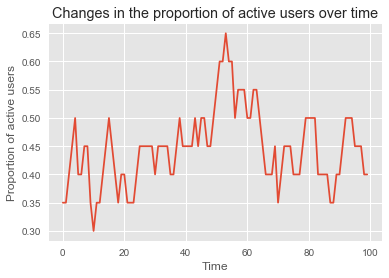

In [54]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

status = ['a', 'p']
types = ['R', 'AA', 'BA', 'P']
agents_num = 20
size = 50


class Agent:
    def __init__(self, agents_num):
        self.id = np.array(range(agents_num))

        self.x = np.random.randint(0, size, agents_num)
        self.y = np.random.randint(0, size, agents_num)
        self.age = np.random.randint(50, 100, agents_num)
        self.aw_vector = np.random.randint(0, 2, agents_num)
        
    def make_agent(self, status, types, age, inf):
        return [status, types, age, inf]

    def make_population(self, status, types, agents_num):

        population = []

        for i in range(agents_num):

            agent = self.make_agent(np.random.choice(status), np.random.choice(types), np.random.choice(self.age), self.aw_vector[i])
            population.append(agent)
        return population

    def count(self, population):
        t = 0.
        for agent in population:
            if agent[0] == 'a':
                t += 1
        return t / len(population)

    def choose_pair(self, population):
        i = np.random.randint(0, len(population) - 1)
        j = np.random.randint(0, len(population) - 1)

        while i == j:
            j = np.random.randint(0, len(population) - 1)

        return [population[i], population[j]]

    def interact(self, listener, producer):
        #if (listener[1] == 'R' or listener[1] == 'AA') and (producer[1] == 'R' or producer[1] == 'AA'):
        #self.age -= 1
        #if self.age 
            if listener[0] == 'a' and producer[0] != 'a' and listener[3] == 1 :
                producer[0] = 'a'
                return producer
            elif listener[0] == 'a' and producer == 'a':
                return producer
            elif listener[0] != 'a' and producer[0] == 'a' and producer[3] == 1 :
                listener[0] = 'a'
                return listener
            else:
                listener[0] = np.random.choice(['a', 'p'])
                return listener
        
agents = Agent(agents_num)
population = agents.make_population(status, types, agents_num)
#print(agents.id)
#print(agents.x)
#print(agents.y)
#print(agents.count(population))
pair = agents.choose_pair(population)
#print(pair)
#print(agents.interact(pair[0], pair[1]))


def simulate(agents_num, k):
    population = agents.make_population(status, types, agents_num)

    proportion = []

    for i in range(k):
            pair = agents.choose_pair(population)
            agents.interact(pair[0], pair[1])
            proportion.append(agents.count(population))
            agents.choose_pair(population)[0][0] = 'p'
    return population, proportion

new_pop, proportion = simulate(agents_num, 100)
print(new_pop)

plt.plot(proportion)
plt.title('Changes in the proportion of active users over time')
plt.xlabel('Time')
plt.ylabel('Proportion of active users')

#plt.savefig('graphic.jpg')

In [54]:
print(agents.aw_vector)

[1 1 1 0 0 0 0 0 1 1 1 0 0 0 1 0 0 0 0 1]
